<a href="https://colab.research.google.com/github/hildj/pca_assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [ ]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

In [2]:
! git clone https://github.com/hildj/pca_assignment

Cloning into 'pca_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 1.54 MiB | 12.95 MiB/s, done.


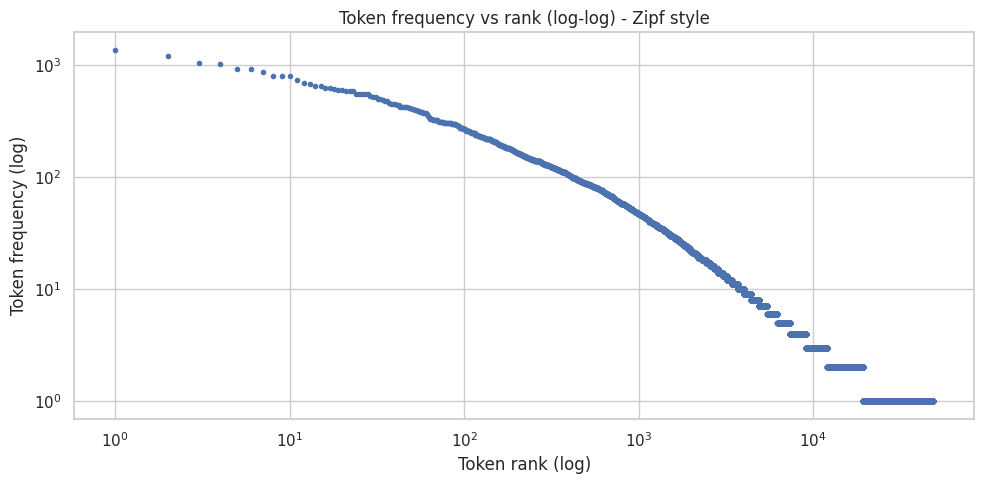

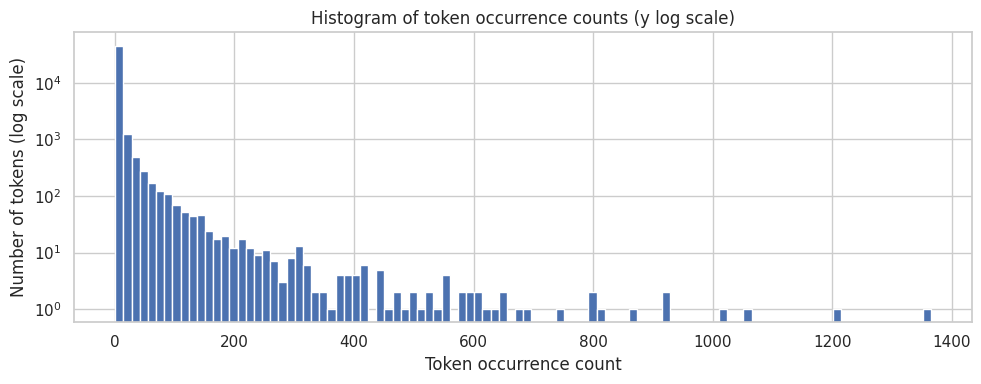

Top 20 tokens by frequency:
      token  count  rank
        new   1365     1
       date   1202     2
        get   1052     3
     please   1022     4
      enron    927     5
       like    923     6
       2002    869     7
      would    806     8
        one    798     9
    message    795    10
       call    740    11
       free    691    12
   software    680    13
       dear    651    14
       know    644    15
      email    629    16
       url:    625    17
       time    609    18
      start    604    19
linguistics    598    20

Q1 OBSERVATION:
The distribution is highly skewed: a few tokens occur very often while most tokens occur rarely (a long tail). On a log-log plot it looks roughly like Zipf's law (a straight-line-ish decay), indicating heavy-tailed token frequencies.


In [4]:
import pickle
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

# -------------------------
# Q1: Plot histogram of token frequencies
# -------------------------
with open('/content/pca_assignment/data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

token_count = Counter(all_tokens)
token_freq = token_count.most_common()  # list of (token, freq)

# Convert to DataFrame for convenience
tf = pd.DataFrame(token_freq, columns=['token', 'count'])

# Plot histogram (log-log style to show heavy tail)
plt.figure(figsize=(10,5))
# Plot frequency distribution (rank vs frequency) - classic Zipf-like plot
tf['rank'] = np.arange(1, len(tf) + 1)
plt.loglog(tf['rank'], tf['count'], marker='.', linewidth=0)
plt.xlabel('Token rank (log)')
plt.ylabel('Token frequency (log)')
plt.title('Token frequency vs rank (log-log) - Zipf style')
plt.tight_layout()
plt.show()

# Also show histogram of counts (linear, but with log y)
plt.figure(figsize=(10,4))
plt.hist(tf['count'], bins=100)
plt.yscale('log')
plt.xlabel('Token occurrence count')
plt.ylabel('Number of tokens (log scale)')
plt.title('Histogram of token occurrence counts (y log scale)')
plt.tight_layout()
plt.show()

# Print top 20 tokens
print("Top 20 tokens by frequency:")
print(tf.head(20).to_string(index=False))

# Short answer for Q1 (printed)
print("\nQ1 OBSERVATION:")
print("The distribution is highly skewed: a few tokens occur very often while most tokens occur rarely (a long tail). "
      "On a log-log plot it looks roughly like Zipf's law (a straight-line-ish decay), indicating heavy-tailed token frequencies.")

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [6]:
# -------------------------
# Q2: Load data, split, run regression, find influential words
# -------------------------

# Load data
phishing_df = pd.read_parquet('/content/pca_assignment/data/Phishing_clean.parquet')

# Separate features (X) and target (y)
X = phishing_df.drop('Email Type', axis=1)
y = phishing_df['Email Type']

# Perform 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test) # Changed from y_test to X_test

# Calculate R^2 on train and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 on training set: {r2_train:.4f}")
print(f"R^2 on test set: {r2_test:.4f}")

# Find words with largest coefficients
coefficients = pd.DataFrame({'token': X.columns, 'coefficient': model.coef_})
coefficients['abs_coefficient'] = np.abs(coefficients['coefficient'])

# Get top 10 words with largest absolute coefficients
top_influential_words = coefficients.sort_values(by='abs_coefficient', ascending=False).head(10)

print("\nTop 10 words with largest absolute coefficients:")
print(top_influential_words[['token', 'coefficient']].to_string(index=False))

R^2 on training set: 0.7670
R^2 on test set: 0.6659

Top 10 words with largest absolute coefficients:
            token  coefficient
     intervention    -1.259257
        localized     0.824350
          thermal     0.747006
          crawler     0.696167
background-image:    -0.622909
       helvetica,     0.598560
            aging     0.594956
            form.     0.576886
            gray;    -0.574480
         a:active     0.574480


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

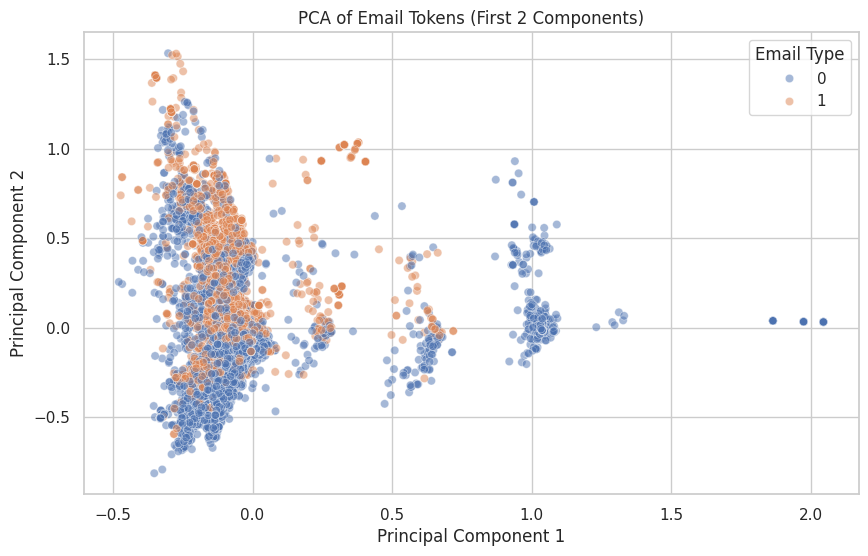

Explained variance ratio by PC1: 0.0111
Explained variance ratio by PC2: 0.0086
Total explained variance by first 2 components: 0.0197


In [7]:
# -------------------------
# Q3: Perform PCA and plot the first two components
# -------------------------

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y.reset_index(drop=True) # Add the target variable

# Plot the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Email Type', data=pca_df, alpha=0.5)
plt.title('PCA of Email Tokens (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio by PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Explained variance ratio by PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Total explained variance by first 2 components: {pca.explained_variance_ratio_.sum():.4f}")

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [9]:
# -------------------------
# Q4: Run regression on 2610 principal components
# -------------------------

# Perform PCA with 2610 components
pca_full = PCA(n_components=2610)
X_pca_full = pca_full.fit_transform(X)

# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_full, y, test_size=0.2, random_state=42)

# Run linear regression on PCA components
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

# Predict on train and test sets
y_train_pred_pca = model_pca.predict(X_train_pca)
y_test_pred_pca = model_pca.predict(X_test_pca)

# Calculate R^2 on train and test sets
r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print(f"R^2 on training set (PCA): {r2_train_pca:.4f}")
print(f"R^2 on test set (PCA): {r2_test_pca:.4f}")

# Compare performance to the original linear regression (from Q2)
print("\nComparison to original linear regression:")
print(f"Original R^2 on training set: {r2_train:.4f}")
print(f"Original R^2 on test set: {r2_test:.4f}")

R^2 on training set (PCA): 0.7662
R^2 on test set (PCA): 0.6684

Comparison to original linear regression:
Original R^2 on training set: 0.7670
Original R^2 on test set: 0.6659


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components reduces dimensionality and aggregates correlated token features into orthogonal directions that capture most variance This reduces overfitting risk, improves numerical stability (less multicollinearity), and can give similar predictive performance with far fewer parameters. PCA also speeds up training and reduces variance at the expense of some interpretability. PCs are linear combos of many tokens.